# Phenotyping Pipeline SIFIBR

# 0. Импортируем библиотеки и загружаем данные

In [1]:
import numpy as np
import cv2
import os
import csv
from datetime import datetime
import json
import pandas as pd
import seaborn as sns
import scipy.stats
import matplotlib.pyplot as plt
from plantcv import plantcv as pcv
from plantcv.parallel import WorkflowInputs

In [ ]:
import torch
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [2]:
analysis_date = '2025_01_07_12_00'

In [3]:
output_dir = os.path.join("./SIFIBR_data/", analysis_date)
os.makedirs(output_dir, exist_ok=True)
output_pots_dir = output_dir + "/pots/"
output_hists_dir = output_dir + "/hists/"
output_data_dir = output_dir + "/data/"

os.makedirs(output_pots_dir, exist_ok=True)
os.makedirs(output_hists_dir, exist_ok=True)
os.makedirs(output_data_dir, exist_ok=True)

# 1. Баланс белого

In [110]:
args = WorkflowInputs(
    images=[f"./SIFIBR_data/IMG_{analysis_date}.jpg"],
    names="image1",
    result="sifibr_analysis_results.json",
    outdir=".",
    writeimg=False,
    debug="plot")

In [111]:
# Set debug to the global parameter
pcv.params.debug = args.debug

# Set plotting size (default = 100)
pcv.params.dpi = 100

# Increase text size and thickness to make labels clearer
# (size may need to be altered based on original image size)
pcv.params.text_size = 10
pcv.params.text_thickness = 20

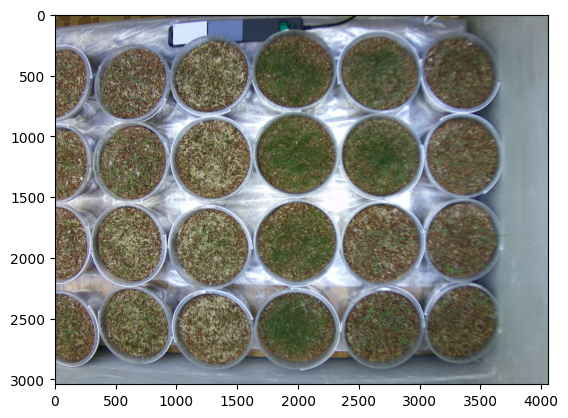

In [112]:
img, path, filename = pcv.readimage(filename=args.image1)

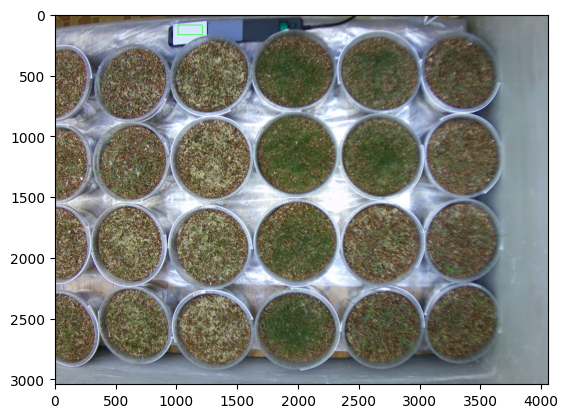

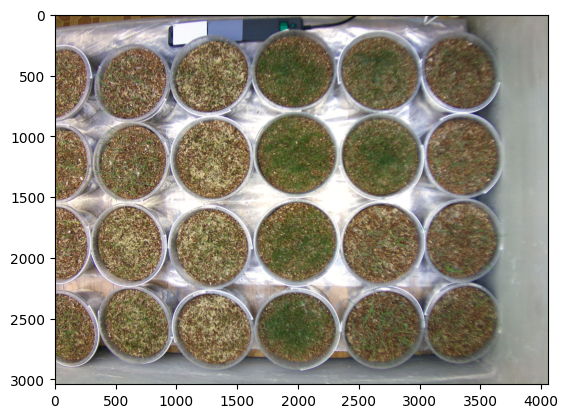

In [113]:
# Set global debug behavior to None (default), "print" (to file), or "plot" (Jupyter Notebooks or X11)
pcv.params.debug = "plot"

# Corrects image based on color standard and stores output as corrected_img
corrected_img = pcv.white_balance(img=img, mode='hist', roi=[1010, 90, 200, 80])

In [114]:
resized_img = cv2.resize(corrected_img, (0, 0), fx=0.25, fy=0.25)
cropped_img = resized_img[25:, 70:950] 
blurred = cv2.bilateralFilter(cropped_img,9,150,150)

In [115]:
hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)

# Диапазон коричневого цвета
lower_brown = np.array([0, 80, 0])
upper_brown = np.array([30, 150, 230])

mask_brown = cv2.inRange(hsv, lower_brown, upper_brown)

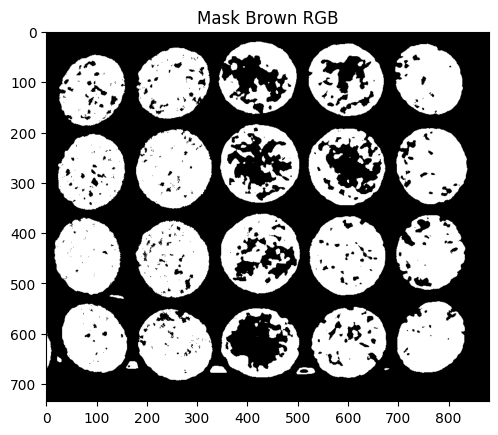

In [116]:
plt.imshow(cv2.cvtColor(mask_brown, cv2.COLOR_RGB2BGR))
plt.title('Mask Brown RGB')
plt.show()

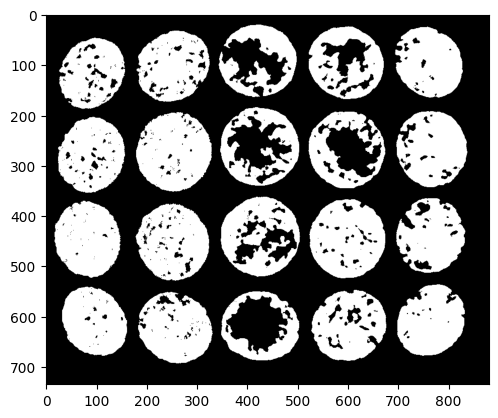

In [122]:
fill_mask = pcv.fill(bin_img=mask_brown, size=1000)
# fill_mask[67:100, 351:360] = 255

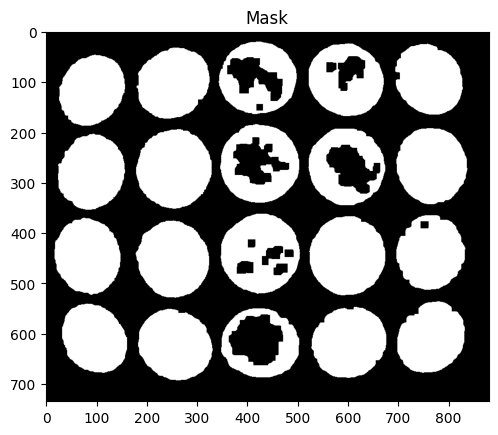

In [123]:
kernel = np.ones((13, 13), np.uint8)
closed_mask = cv2.morphologyEx(fill_mask, cv2.MORPH_CLOSE, kernel)

plt.imshow(cv2.cvtColor(closed_mask, cv2.COLOR_RGB2BGR))
plt.title('Mask')
plt.show()

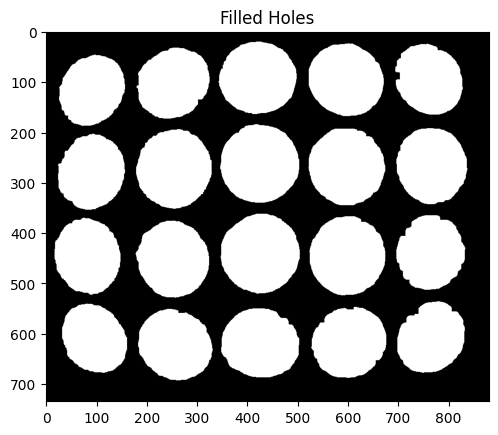

In [124]:
# Копируем маску и создаем холст
im_floodfill = closed_mask.copy()
h, w = closed_mask.shape[:2]
mask_flood = np.zeros((h+2, w+2), np.uint8)

# Заливаем фон (0,0) как внешний фон
cv2.floodFill(im_floodfill, mask_flood, (0, 0), 255)

# Инвертируем залитое, чтобы получить только дыры
im_floodfill_inv = cv2.bitwise_not(im_floodfill)

# Объединяем оригинальную маску и инвертированную заливку
filled_mask = closed_mask | im_floodfill_inv

plt.imshow(cv2.cvtColor(filled_mask, cv2.COLOR_RGB2BGR))
plt.title('Filled Holes')
plt.show()

In [125]:
# Убедись, что маска — одноцветная (grayscale)
if len(filled_mask.shape) == 3:
    filled_mask = cv2.cvtColor(filled_mask, cv2.COLOR_BGR2GRAY)

# Применяем маску: оставляем только ту часть изображения, где маска = белая (255)
mask_pots = cv2.bitwise_and(cropped_img, cropped_img, mask=filled_mask)

cv2.imshow("Result", mask_pots)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [126]:
# Найдём контуры
contours, _ = cv2.findContours(filled_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Вычисляем центры всех контуров
centers = []
for i, cnt in enumerate(contours):
    M = cv2.moments(cnt)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centers.append((i, cX, cY))  # сохраняем индекс и координаты
    else:
        centers.append((i, cnt[0][0][0], cnt[0][0][1]))

# Сортируем: сначала по Y (строки), потом по X (внутри строки)
# Используем "кластеризацию по строкам" по Y
def sort_grid_like(centers, row_tolerance=20):
    # Сначала отсортируем по Y (строки)
    centers = sorted(centers, key=lambda x: x[2])
    rows = []
    current_row = []

    for c in centers:
        if not current_row:
            current_row.append(c)
        else:
            # Если Y примерно такой же — та же строка
            if abs(c[2] - current_row[-1][2]) < row_tolerance:
                current_row.append(c)
            else:
                # Сортируем строку по X и добавляем
                rows.append(sorted(current_row, key=lambda x: x[1]))
                current_row = [c]
    if current_row:
        rows.append(sorted(current_row, key=lambda x: x[1]))

    # Разворачиваем в общий список
    sorted_indices = [i for row in rows for (i, _, _) in row]
    return sorted_indices

# Получаем индексы контуров в правильном порядке
ordered_indices = sort_grid_like(centers)

# Копия изображения
contour_img = cropped_img.copy()

# Рисуем контуры и правильные номера
for label, idx in enumerate(ordered_indices):
    cnt = contours[idx]
    M = cv2.moments(cnt)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = cnt[0][0]

    cv2.drawContours(contour_img, [cnt], -1, (0, 255, 0), 2)
    cv2.putText(contour_img, str(label + 1), (cX, cY),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

# Показать
cv2.imshow("Labeled Pots", contour_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [127]:
cv2.imwrite(os.path.join(output_dir, 'contours_pots.png'), contour_img)
cv2.imwrite(os.path.join(output_dir, 'mask_pots.png'), mask_pots)
cv2.imwrite(os.path.join(output_dir, 'preprocessed.jpg'), cropped_img)

True

In [128]:
pcv.params.debug = "none"

for label, idx in enumerate(ordered_indices):
    if label in [0, 5]:
        continue

    cnt = contours[idx]
    x, y, w, h = cv2.boundingRect(cnt)
    cropped_pot = cropped_img[y:y+h, x:x+w]

    # Маска для объекта
    mask = np.zeros((h, w), dtype=np.uint8)
    cnt_shifted = cnt - [x, y]
    cv2.drawContours(mask, [cnt_shifted], -1, 255, -1)

    # Сохраняем PNG с альфа-каналом (прозрачностью)
    cropped_pot_rgba = cv2.cvtColor(cropped_pot, cv2.COLOR_BGR2BGRA)
    cropped_pot_rgba[:, :, 3] = mask

    pot_filename = os.path.join(output_pots_dir, f"pot_{label + 1}.png")
    cv2.imwrite(pot_filename, cropped_pot_rgba)

    # ---------- Гистограмма цвета ----------
    rgb_img = cv2.cvtColor(cropped_pot, cv2.COLOR_BGR2RGB)

    pcv.outputs.clear()
    pcv.analyze.color(rgb_img=rgb_img, labeled_mask=mask, n_labels=1, colorspaces='hsv')
    json_path = os.path.join(output_data_dir, f"pot_{label+1}_color.json")
    pcv.outputs.save_results(filename=json_path)
    
    chart = pcv.visualize.histogram(cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV), mask, bins=25)
    
    hist_filename = os.path.join(output_hists_dir, f"pot_{label + 1}_color_hist.png")
    chart.save(hist_filename)  # Altair Chart method

# 2. Формирование даннных

In [129]:
#Обрати внимание на время
analysis_date

'2025_01_07_12_00'

In [130]:
def extract_color_statistics_from_image(image_path, plant_id=None, day=None, month=None, year=None):
    # Загрузить изображение с помощью OpenCV
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Не удалось загрузить изображение {image_path}")

    # Конвертировать BGR в HSV
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Разделить каналы
    h_channel = hsv_img[:, :, 0]  # Hue: 0-179 в OpenCV
    s_channel = hsv_img[:, :, 1]  # Saturation: 0-255
    v_channel = hsv_img[:, :, 2]  # Value: 0-255

    # Нормализовать каналы для удобства:
    hue_vals = h_channel.flatten() * 2  # Hue: 0-360
    sat_vals = s_channel.flatten() / 255.0  # Saturation 0-1
    val_vals = v_channel.flatten() / 255.0  # Value 0-1

    # Корректное вычисление среднего для угловой величины Hue
    mean_hue = scipy.stats.circmean(hue_vals, high=360, low=0)
    std_hue = scipy.stats.circstd(hue_vals, high=360, low=0)

    stats = {
        "plant_id": plant_id,
        "hue_mean": mean_hue,
        "hue_std": std_hue,
        "hue_min": np.min(hue_vals),
        "hue_max": np.max(hue_vals),
        "hue_p25": np.percentile(hue_vals, 25),
        "hue_p50": np.percentile(hue_vals, 50),
        "hue_p75": np.percentile(hue_vals, 75),
        "hue_range": np.max(hue_vals) - np.min(hue_vals),

        "saturation_mean": np.mean(sat_vals),
        "saturation_std": np.std(sat_vals),
        "saturation_min": np.min(sat_vals),
        "saturation_max": np.max(sat_vals),
        "saturation_p25": np.percentile(sat_vals, 25),
        "saturation_p50": np.percentile(sat_vals, 50),
        "saturation_p75": np.percentile(sat_vals, 75),
        "saturation_range": np.max(sat_vals) - np.min(sat_vals),

        "value_mean": np.mean(val_vals),
        "value_std": np.std(val_vals),
        "value_min": np.min(val_vals),
        "value_max": np.max(val_vals),
        "value_p25": np.percentile(val_vals, 25),
        "value_p50": np.percentile(val_vals, 50),
        "value_p75": np.percentile(val_vals, 75),
        "value_range": np.max(val_vals) - np.min(val_vals),

        "hue_skew": scipy.stats.skew(hue_vals),
        "saturation_skew": scipy.stats.skew(sat_vals),
        "value_skew": scipy.stats.skew(val_vals),

        "hue_kurtosis": scipy.stats.kurtosis(hue_vals),
        "saturation_kurtosis": scipy.stats.kurtosis(sat_vals),
        "value_kurtosis": scipy.stats.kurtosis(val_vals),
    }
    
    def calculate_green_ratio_in_pot(image_path: str) -> float:
        # Загрузка изображения с альфа-каналом
        pot = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        
        # Проверка наличия альфа-канала
        if pot.shape[2] != 4:
            raise ValueError("Изображение не содержит альфа-канала.")
    
        # Преобразование в HSV
        pot_hsv = cv2.cvtColor(pot[:, :, :3], cv2.COLOR_BGR2HSV)
    
        # Извлечение канала оттенков
        h_channel = pot_hsv[:, :, 0]
    
        # Гистограмма по H и определение пика в зелёном диапазоне
        hist = cv2.calcHist([h_channel], [0], None, [180], [0, 180])
        green_hist_range = hist[35:86]
        absolute_peak_hue = np.argmax(green_hist_range) + 35
    
        # Адаптивный зелёный диапазон ±10
        lower_green = np.array([max(absolute_peak_hue - 10, 0), 50, 50])
        upper_green = np.array([min(absolute_peak_hue + 10, 179), 255, 255])
    
        # Маска по зелёному
        mask_green = cv2.inRange(pot_hsv, lower_green, upper_green)
    
        # Маска горшка из альфа-канала
        alpha = pot[:, :, 3]
        _, mask_pot = cv2.threshold(alpha, 0, 255, cv2.THRESH_BINARY)
    
        # Количество пикселей
        pot_pixels_count = cv2.countNonZero(mask_pot)
        mask_green_in_pot = cv2.bitwise_and(mask_green, mask_pot)
        segmented_pixels_in_pot = cv2.countNonZero(mask_green_in_pot)
    
        # Расчёт процента
        if pot_pixels_count == 0:
            return 0.0
    
        return round(segmented_pixels_in_pot / pot_pixels_count * 100, 2)
    
    # Функция для названий растений
    def get_plant_name(pid):
        if pid in [5, 10, 14, 15, 19, 20]:
            return 'Plant K'
        elif pid in [3, 4, 8, 9, 13, 18]:
            return 'Plant SH'
        else:
            return 'Plant O'

    # Функция для типа воды
    def get_water_type(pid):
        if pid in [4, 9, 12, 15, 17, 20]:
            return 'Water IRK'
        elif pid in [2, 5, 7, 10, 13, 18]:
            return 'Water B2'
        else:
            return 'Water B4'
            
    stats['green_area_ratio'] = calculate_green_ratio_in_pot(image_path)
    stats['plants'] = get_plant_name(plant_id)
    stats['water_type'] = get_water_type(plant_id)

    # Вычисляем количество дней с начала эксперимента
    if day is not None and month is not None and year is not None:
        start_date = datetime(year=2025, month=6, day=17)
        current_date = datetime(year=year, month=month, day=day)
        stats["days_gone"] = (current_date - start_date).days

    # Округляем числовые значения для удобства
    for k, v in stats.items():
        if isinstance(v, (float, np.floating)):
            stats[k] = round(v, 2)

    return stats

In [131]:
csv_filename = "sifibr_plant_data.csv"

# Чтобы записать заголовок один раз, возьмем поле из первого файла
first_file = False

for filename in os.listdir(output_pots_dir):
    plant_id = int(filename.split('_')[1].split('.')[0])
    day = int(analysis_date.split('_')[1])
    month = int(analysis_date.split('_')[2])
    year = int(analysis_date.split('_')[0])

    stats = extract_color_statistics_from_image(output_pots_dir + filename, plant_id, day, month, year)
    
    # Записываем в CSV
    with open(csv_filename, 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=stats.keys())
        if first_file:
            writer.writeheader()  # пишем заголовок только один раз
            first_file = False
        writer.writerow(stats)
    

# 3. Анализ данных

In [5]:
csv_filename = "sifibr_plant_data.csv"

In [6]:
df = pd.read_csv('C:/VsCodeProjects/ML/PhenoPi/' + csv_filename)

In [7]:
df

,plant_id,hue_mean,hue_std,hue_min,hue_max,hue_p25,hue_p50,hue_p75,hue_range,saturation_mean,...,hue_skew,saturation_skew,value_skew,hue_kurtosis,saturation_kurtosis,value_kurtosis,green_area_ratio,plants,water_type,days_gone
0,10,33.87,43.46,0,254,28.0,34.0,42.0,254,0.36,...,2.26,-1.10,0.89,3.65,0.19,1.05,0.00,Plant K,Water B2,9
1,11,34.59,23.99,0,254,26.0,34.0,44.0,254,0.36,...,4.31,-0.39,0.13,22.20,-0.46,-0.70,0.47,Plant O,Water B4,9
2,12,37.54,30.89,0,254,30.0,38.0,46.0,254,0.33,...,3.35,-0.52,0.24,11.03,-0.67,-0.67,0.00,Plant O,Water IRK,9
3,13,38.23,26.43,0,254,32.0,38.0,46.0,254,0.38,...,3.84,-0.92,1.19,16.26,-0.40,0.54,0.00,Plant SH,Water B2,9
4,14,35.24,31.90,0,254,28.0,36.0,44.0,254,0.36,...,3.24,-0.91,0.98,10.22,-0.32,0.57,2.22,Plant K,Water B4,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,4,50.52,41.54,0,254,38.0,50.0,68.0,254,0.33,...,2.29,-0.95,1.70,4.28,0.01,2.71,48.87,Plant SH,Water IRK,14
104,5,38.66,38.84,0,254,30.0,38.0,50.0,254,0.34,...,2.56,-1.04,2.27,5.65,0.16,5.76,14.21,Plant K,Water B2,14
105,7,38.99,27.71,0,254,30.0,40.0,48.0,254,0.34,...,3.63,-0.65,0.47,14.99,-0.56,-0.48,0.00,Plant O,Water B2,14
106,8,55.84,29.21,0,254,44.0,58.0,70.0,254,0.41,...,2.75,-1.05,1.62,10.82,-0.20,1.56,65.28,Plant SH,Water B4,14


In [8]:
df.columns

Index(['plant_id', 'hue_mean', 'hue_std', 'hue_min', 'hue_max', 'hue_p25',
       'hue_p50', 'hue_p75', 'hue_range', 'saturation_mean', 'saturation_std',
       'saturation_min', 'saturation_max', 'saturation_p25', 'saturation_p50',
       'saturation_p75', 'saturation_range', 'value_mean', 'value_std',
       'value_min', 'value_max', 'value_p25', 'value_p50', 'value_p75',
       'value_range', 'hue_skew', 'saturation_skew', 'value_skew',
       'hue_kurtosis', 'saturation_kurtosis', 'value_kurtosis',
       'green_area_ratio', 'plants', 'water_type', 'days_gone'],
      dtype='object')

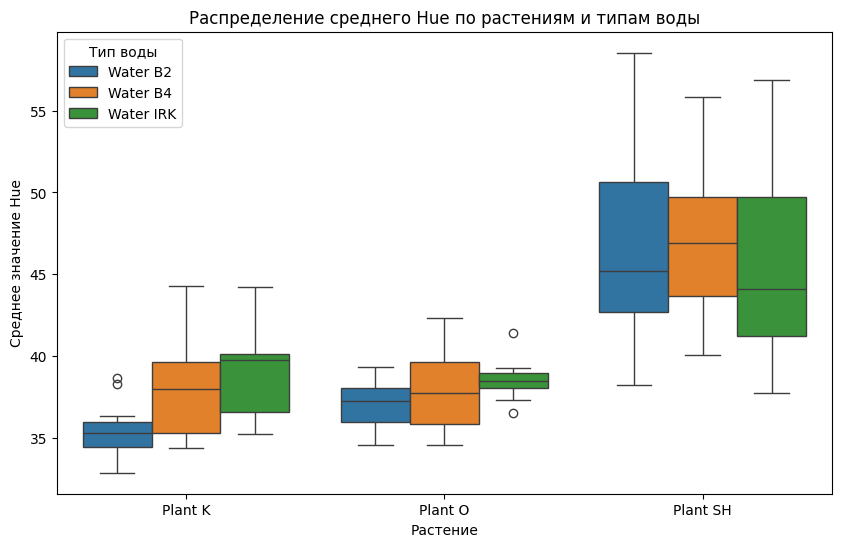

In [136]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='plants', y='hue_mean', hue='water_type')
plt.title('Распределение среднего Hue по растениям и типам воды')
plt.xlabel('Растение')
plt.ylabel('Среднее значение Hue')
plt.legend(title='Тип воды')
plt.show()

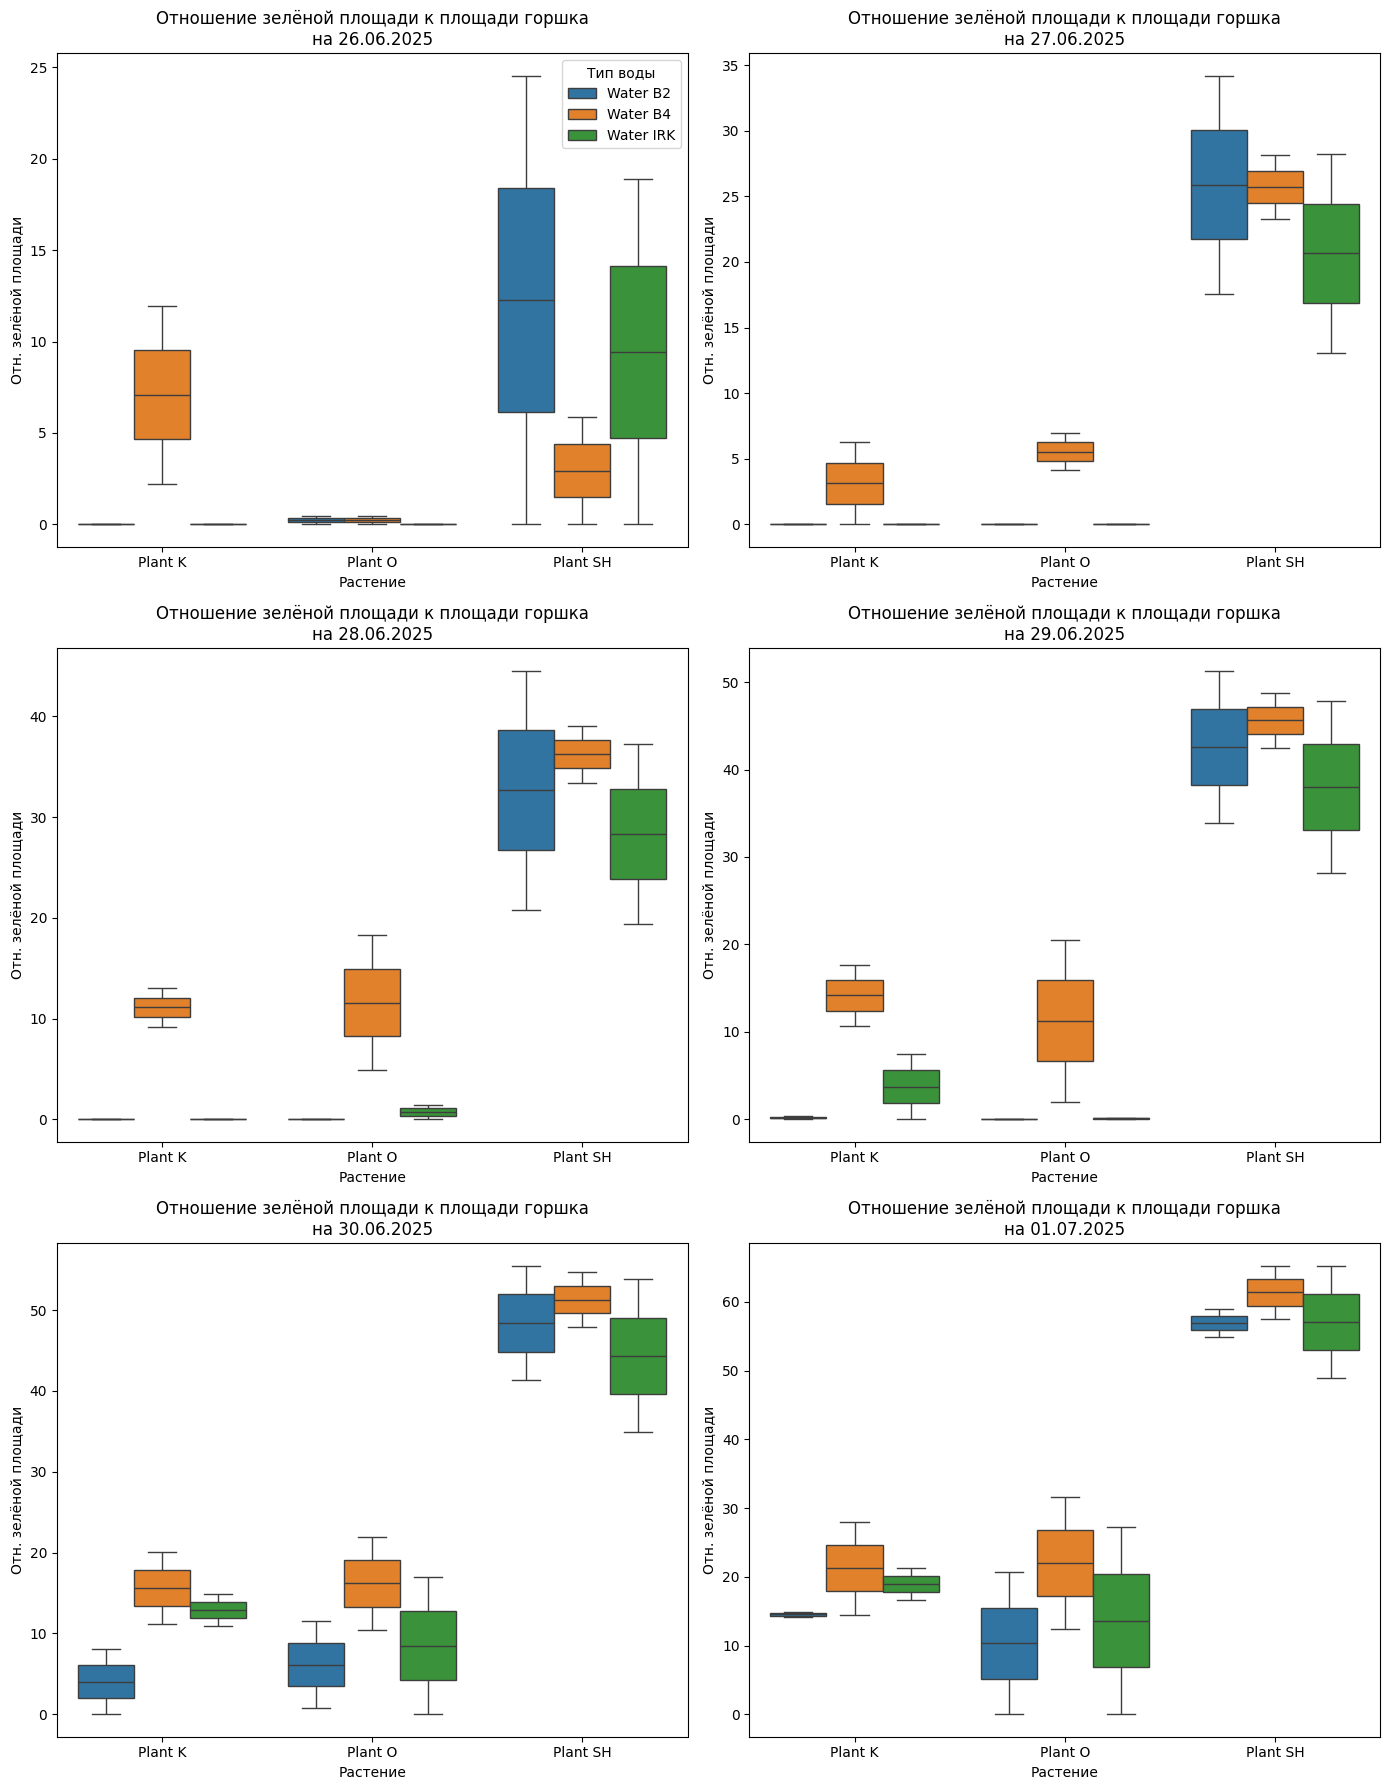

In [23]:
dates_days = [
    ('26.06.2025', 9),
    ('27.06.2025', 10),
    ('28.06.2025', 11),
    ('29.06.2025', 12),
    ('30.06.2025', 13),
    ('01.07.2025', 14)
]

fig, axes = plt.subplots(3, 2, figsize=(14, 18))  
axes = axes.flatten()  

for i, (date, days) in enumerate(dates_days):
    ax = axes[i]
    sns.boxplot(
        data=df[df['days_gone'] == days],
        x='plants',
        y='green_area_ratio',
        hue='water_type',
        ax=ax
    )
    ax.set_title(f'Отношение зелёной площади к площади горшка\nна {date}')
    ax.set_xlabel('Растение')
    ax.set_ylabel('Отн. зелёной площади')
    ax.legend(title='Тип воды')

for i in range(1, len(axes)):
    axes[i].legend_.remove()

plt.tight_layout()
#plt.savefig('./SIFIBR_data/Визуализация данных/Отношение зелёной площади к площади горшка/green_area_ratio_6_days.png', dpi=300, bbox_inches='tight')
plt.show()

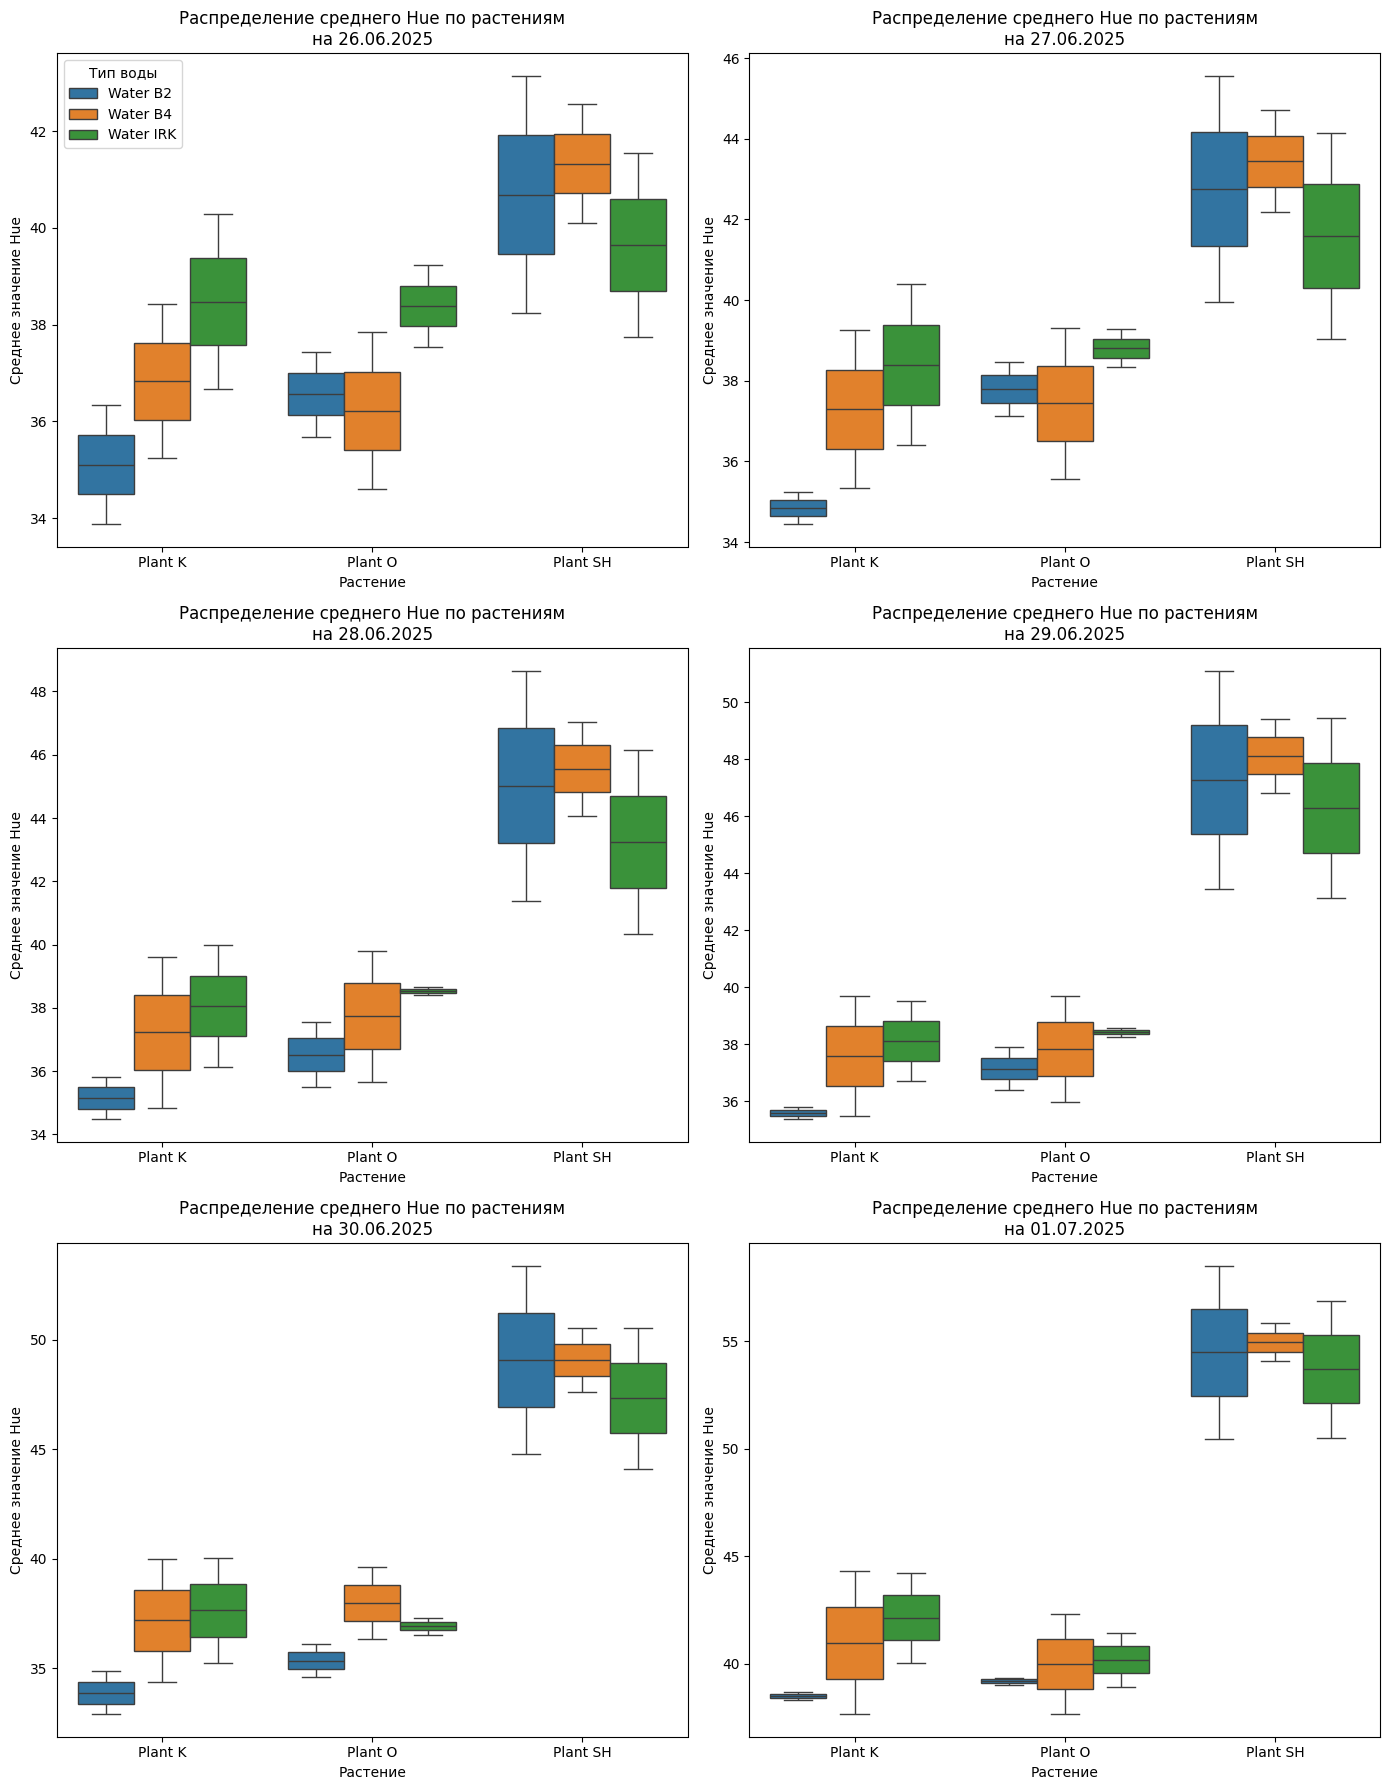

In [27]:
dates_days = [
    ('26.06.2025', 9),
    ('27.06.2025', 10),
    ('28.06.2025', 11),
    ('29.06.2025', 12),
    ('30.06.2025', 13),
    ('01.07.2025', 14)
]

fig, axes = plt.subplots(3, 2, figsize=(14, 18))  
axes = axes.flatten()  

for i, (date, days) in enumerate(dates_days):
    ax = axes[i]
    sns.boxplot(
        data=df[df['days_gone'] == days],
        x='plants',
        y='hue_mean',
        hue='water_type',
        ax=ax
    )
    ax.set_title(f'Распределение среднего Hue по растениям\nна {date}')
    ax.set_xlabel('Растение')
    ax.set_ylabel('Среднее значение Hue')
    ax.legend(title='Тип воды')

for i in range(1, len(axes)):
    axes[i].legend_.remove()

plt.tight_layout()
#plt.savefig('./SIFIBR_data/Визуализация данных/Распределение среднего Hue по растениям/hue_mean_6_days.png', dpi=300, bbox_inches='tight')
plt.show()

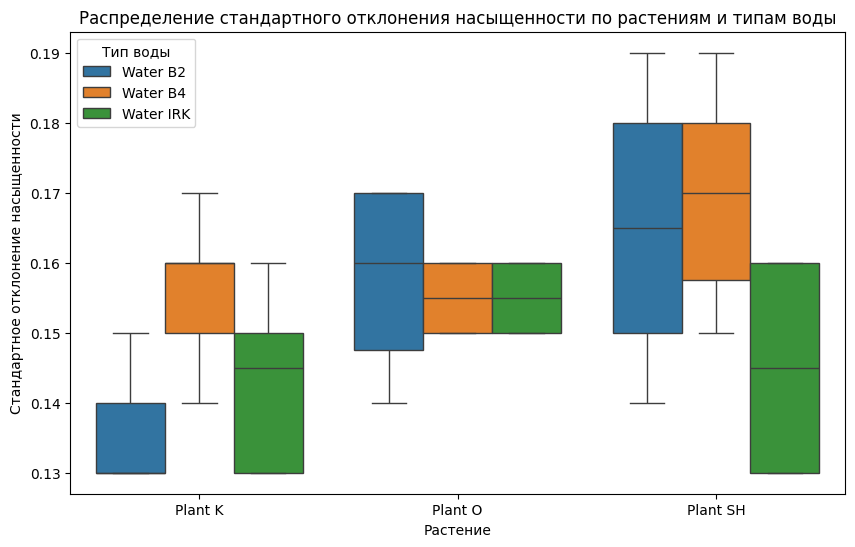

In [346]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='plants', y='saturation_std', hue='water_type')
plt.title('Распределение стандартного отклонения насыщенности по растениям и типам воды')
plt.xlabel('Растение')
plt.ylabel('Стандартное отклонение насыщенности')
plt.legend(title='Тип воды')
plt.show()


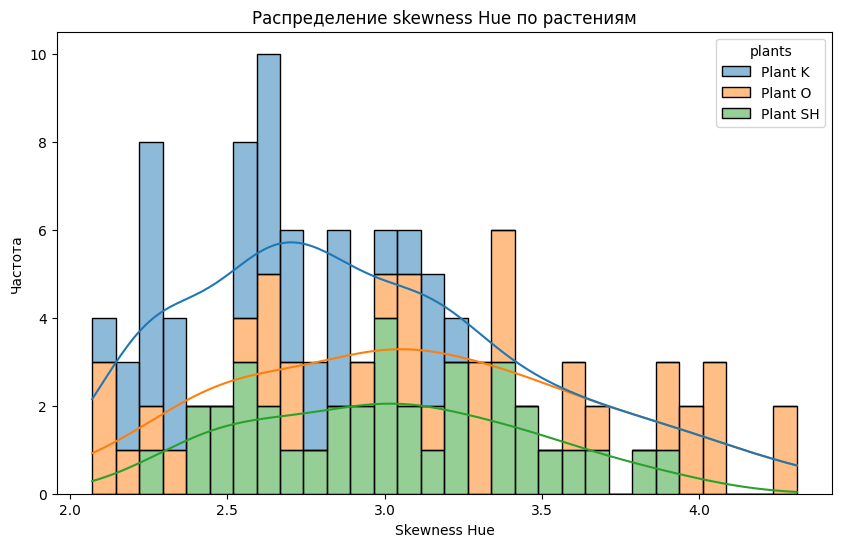

In [347]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='hue_skew', bins=30, kde=True, hue='plants', multiple='stack')
plt.title('Распределение skewness Hue по растениям')
plt.xlabel('Skewness Hue')
plt.ylabel('Частота')
plt.show()


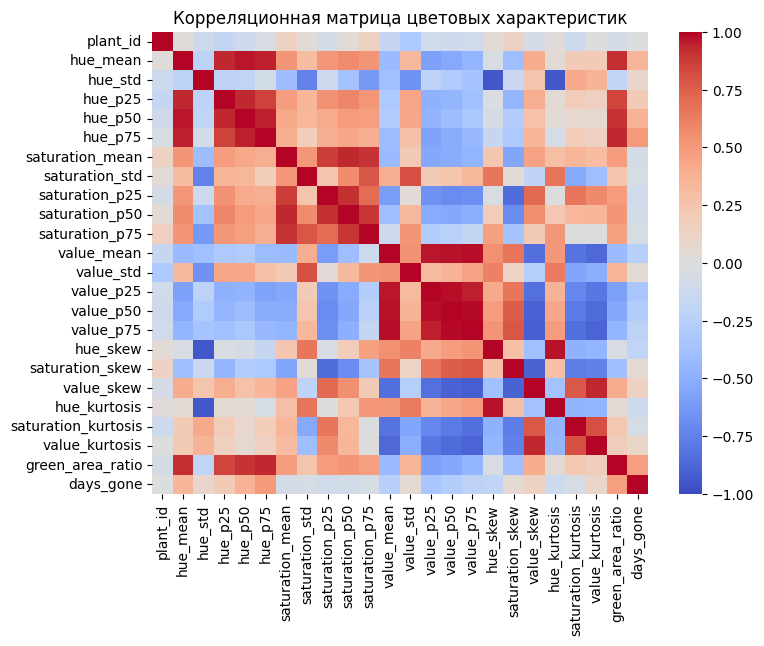

In [41]:
cols_to_drop = ['hue_min', 'hue_max', 'hue_range', 
                'saturation_min', 'saturation_max', 'saturation_range', 
                'value_min', 'value_max', 'value_range']

df_corr = df.drop(columns=cols_to_drop)

corr = df_corr.corr(numeric_only = True)

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Корреляционная матрица цветовых характеристик')
plt.savefig('./SIFIBR_data/Визуализация данных/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

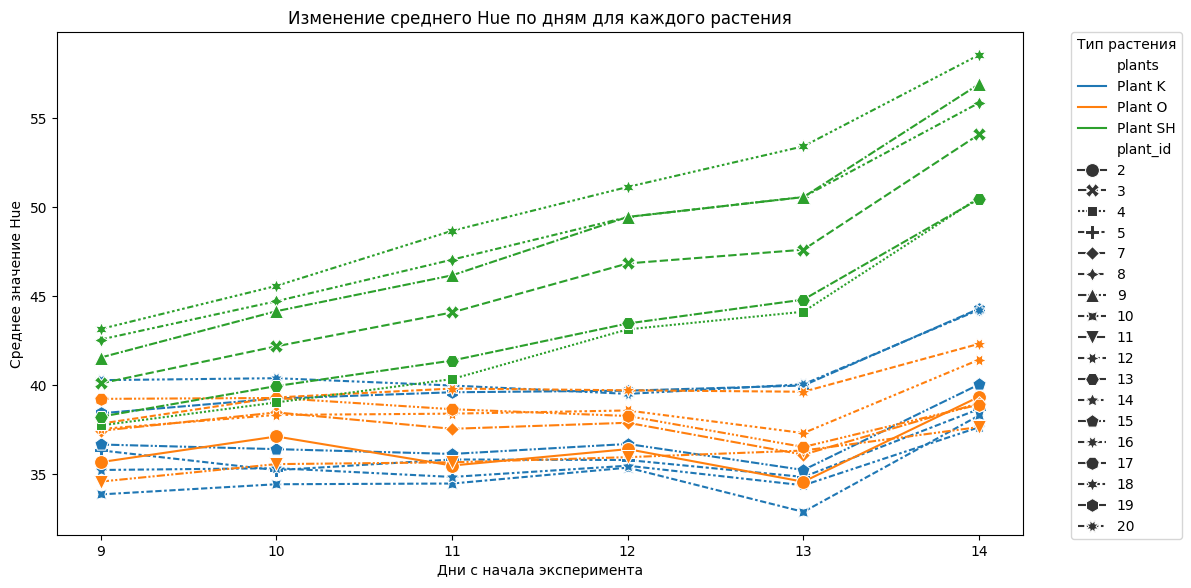

In [30]:
plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=df, x='days_gone', y='hue_mean', hue='plants', style='plant_id', markers=True)

for line in ax.lines:
    line.set_markersize(10) 

plt.title('Изменение среднего Hue по дням для каждого растения')
plt.xlabel('Дни с начала эксперимента')
plt.ylabel('Среднее значение Hue')
plt.legend(title='Тип растения', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.savefig('./SIFIBR_data/Визуализация данных/Изменение среднего Hue по дням для каждого растения/dynamic_hue_6_days.png', dpi=300, bbox_inches='tight')
plt.show()

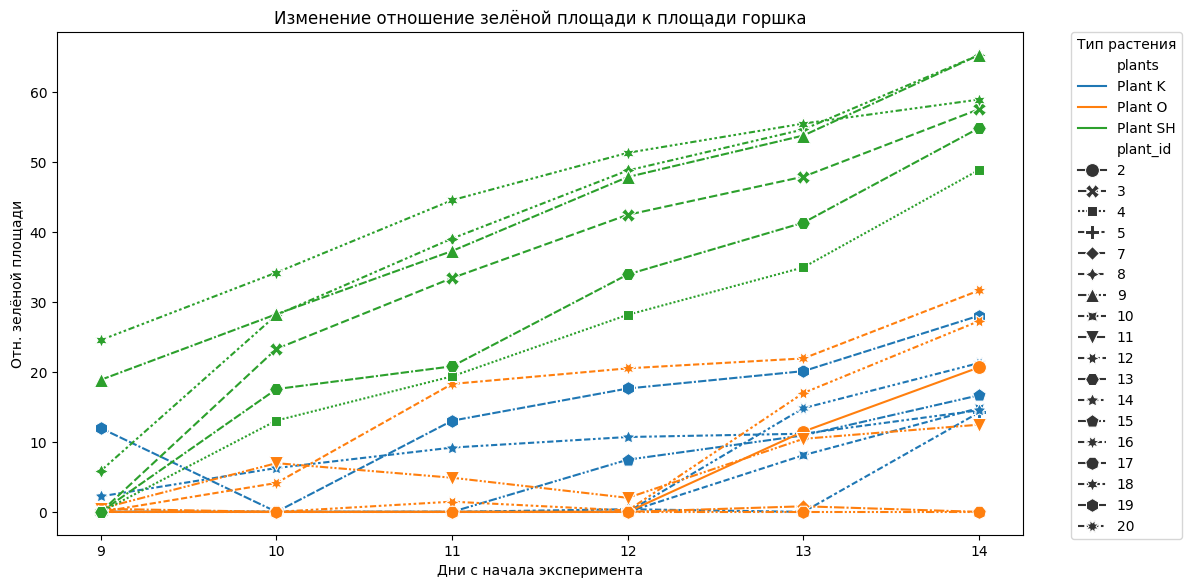

In [32]:
plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=df, x='days_gone', y='green_area_ratio', hue='plants', style='plant_id', markers=True)

for line in ax.lines:
    line.set_markersize(10) 

plt.title('Изменение отношение зелёной площади к площади горшка')
plt.xlabel('Дни с начала эксперимента')
plt.ylabel('Отн. зелёной площади')
plt.legend(title='Тип растения', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.savefig('./SIFIBR_data/Визуализация данных/Изменение отношение зелёной площади к площади горшка/dynamic_green_area_ratio_6_days.png', dpi=300, bbox_inches='tight')
plt.show()

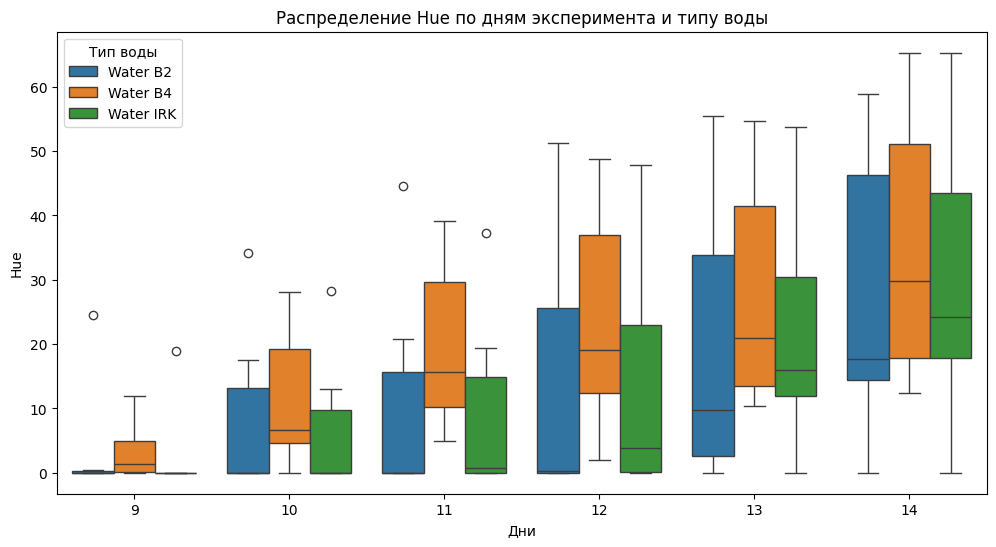

In [33]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='days_gone', y='green_area_ratio', hue='water_type')
plt.title('Распределение Hue по дням эксперимента и типу воды')
plt.xlabel('Дни')
plt.ylabel('Hue')
plt.legend(title='Тип воды')
plt.show()


# Анализ покрытия горшка растением

In [74]:
analysis_date

'2025_26_06_12_00'

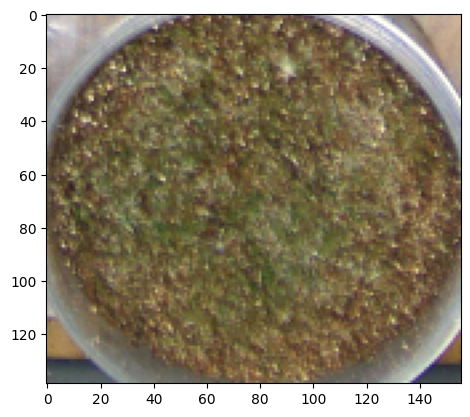

In [75]:
pot = cv2.imread(output_pots_dir + 'pot_18.png', cv2.IMREAD_UNCHANGED)
pot_hsv = cv2.cvtColor(pot, cv2.COLOR_BGR2HSV)
pot_rgb = cv2.cvtColor(pot, cv2.COLOR_BGR2RGB)
plt.imshow(pot_rgb)

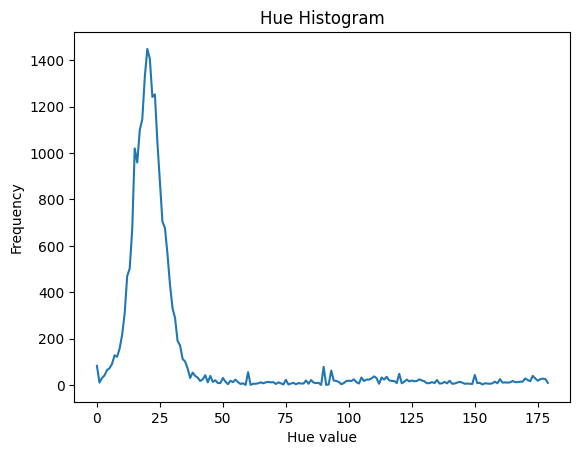

In [76]:
# 2. Извлекаем канал H (оттенок)
h_channel = pot_hsv[:, :, 0]

# 3. Строим гистограмму по H
hist = cv2.calcHist([h_channel], [0], None, [180], [0, 180])

# 4. Показываем гистограмму
plt.plot(hist)
plt.title("Hue Histogram")
plt.xlabel("Hue value")
plt.ylabel("Frequency")
plt.show()

In [77]:
green_hist_range = hist[35:86]  # срез [35:86) — индексы 35...85 включительно

# Находим индекс максимального значения внутри этого диапазона
relative_peak_index = np.argmax(green_hist_range)
absolute_peak_hue = relative_peak_index + 35  # возвращаемся к оригинальной шкале

# Формируем адаптивный диапазон вокруг пика (±10, например)
lower_green = np.array([max(absolute_peak_hue - 10, 0), 50, 50])
upper_green = np.array([min(absolute_peak_hue + 10, 179), 255, 255])

# Сегментация по зелёному
mask_green = cv2.inRange(pot_hsv, lower_green, upper_green)

# применить маску:
resulted_mask = cv2.bitwise_and(cv2.cvtColor(pot_hsv, cv2.COLOR_HSV2BGR), cv2.cvtColor(pot_hsv, cv2.COLOR_HSV2BGR), mask=mask_green)

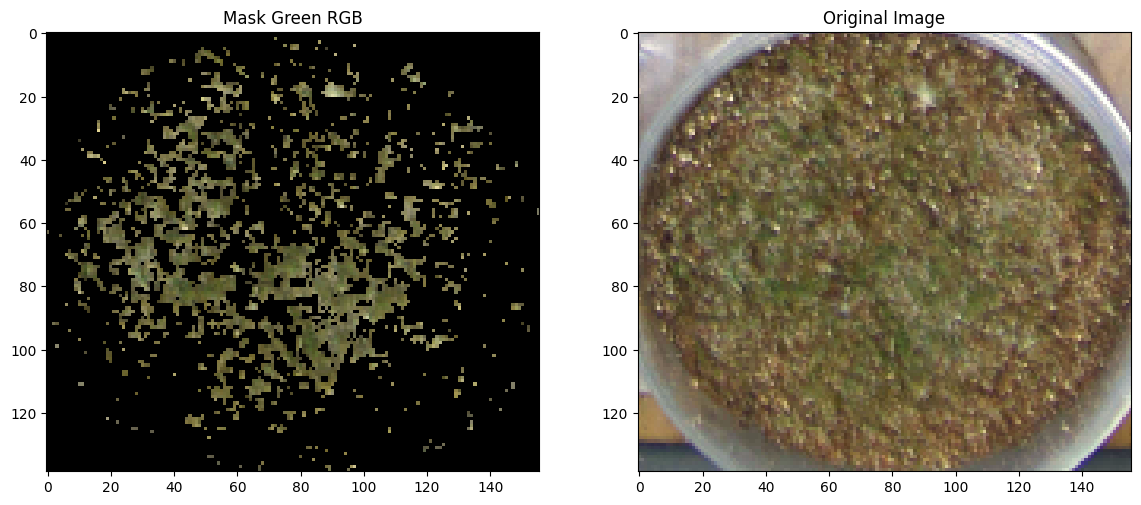

In [78]:
_, ax = plt.subplots(1,2, figsize=(14,10))

ax[0].imshow(cv2.cvtColor(resulted_mask, cv2.COLOR_RGB2BGR))
ax[0].set_title('Mask Green RGB')
ax[1].imshow(cv2.cvtColor(pot_hsv, cv2.COLOR_HSV2RGB))
ax[1].set_title('Original Image')
plt.show()

In [35]:
# Альфа-канал — последний канал
alpha = pot[:, :, 3]

# Создаем маску горшка из альфа-канала (прозрачные пиксели будут 0)
_, mask_pot = cv2.threshold(alpha, 0, 255, cv2.THRESH_BINARY)

# Считаем количество пикселей горшка
pot_pixels_count = cv2.countNonZero(mask_pot)
print("Количество пикселей горшка:", pot_pixels_count)

# Усечём маску зеленого маской горшка
mask_green_in_pot = cv2.bitwise_and(mask_green, mask_pot)

segmented_pixels_in_pot = cv2.countNonZero(mask_green_in_pot)
print("Сегментированных пикселей внутри горшка:", segmented_pixels_in_pot)

Количество пикселей горшка: 14554
Сегментированных пикселей внутри горшка: 3096


In [36]:
ratio = segmented_pixels_in_pot / pot_pixels_count * 100
print(f"Процент сегментированных пикселей от площади горшка: {ratio:.2f}%")

Процент сегментированных пикселей от площади горшка: 21.27%


In [41]:
def calculate_green_ratio_in_pot(image_path: str) -> float:
    # Загрузка изображения с альфа-каналом
    pot = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    
    # Проверка наличия альфа-канала
    if pot.shape[2] != 4:
        raise ValueError("Изображение не содержит альфа-канала.")

    # Преобразование в HSV
    pot_hsv = cv2.cvtColor(pot[:, :, :3], cv2.COLOR_BGR2HSV)

    # Извлечение канала оттенков
    h_channel = pot_hsv[:, :, 0]

    # Гистограмма по H и определение пика в зелёном диапазоне
    hist = cv2.calcHist([h_channel], [0], None, [180], [0, 180])
    green_hist_range = hist[35:86]
    absolute_peak_hue = np.argmax(green_hist_range) + 35

    # Адаптивный зелёный диапазон ±10
    lower_green = np.array([max(absolute_peak_hue - 10, 0), 50, 50])
    upper_green = np.array([min(absolute_peak_hue + 10, 179), 255, 255])

    # Маска по зелёному
    mask_green = cv2.inRange(pot_hsv, lower_green, upper_green)

    # Маска горшка из альфа-канала
    alpha = pot[:, :, 3]
    _, mask_pot = cv2.threshold(alpha, 0, 255, cv2.THRESH_BINARY)

    # Количество пикселей
    pot_pixels_count = cv2.countNonZero(mask_pot)
    mask_green_in_pot = cv2.bitwise_and(mask_green, mask_pot)
    segmented_pixels_in_pot = cv2.countNonZero(mask_green_in_pot)

    # Расчёт процента
    if pot_pixels_count == 0:
        return 0.0

    return round(segmented_pixels_in_pot / pot_pixels_count * 100, 2)

In [42]:
calculate_green_ratio_in_pot(output_pots_dir + 'pot_20.png')

21.27